# Self-Driving Car Engineer Nanodegree Term1
## Project 4 : Advanced Lane Finding
---

In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in the [project repository](https://github.com/udacity/CarND-Advanced-Lane-Lines).

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/571/view) for this project.


The method of computing the calibration and undistortion is in [this repository](https://github.com/udacity/CarND-Camera-Calibration/blob/master/camera_calibration.ipynb).

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import re
%matplotlib inline

## Camera Calibration

### Extract object points and image points for camera calibration.

In [2]:
# prepare object points
nx = 9 # number of inner points in x
ny = 6 # number of inner points in y
# nx, ny = 9, 6 also works why?

# prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0) ..., (6, 5, 0)
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
objpoints = [] #3d points in real world space
imgpoints = [] #2d points in image plane

# Make a list of calibration images
images = sorted(glob.glob('camera_cal/cali*.jpg'))

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    num = re.findall(r'\d+', fname)
    #print(str(num[0]))

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        plt.show()
        # Save jpg
        write_name = 'corners_found'+str(num[0])+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("No corners detected: " + fname)

cv2.destroyAllWindows()

No corners detected: camera_cal/calibration1.jpg
No corners detected: camera_cal/calibration4.jpg
No corners detected: camera_cal/calibration5.jpg


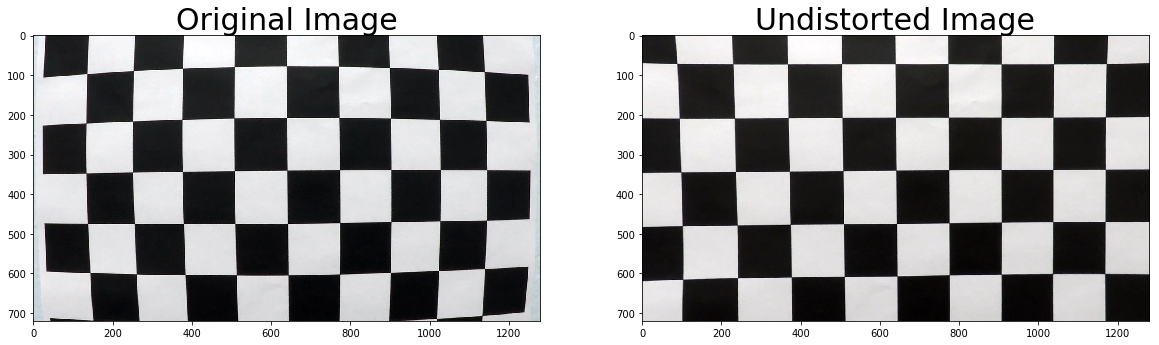

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[0], img.shape[1])

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Find chessboard corvers
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
# Drawing detected corners on an image
img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)


# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)
cv2.imwrite('test_dis.jpg', img)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

## Single image (pipeline)

### An example of distortion-corrected image.

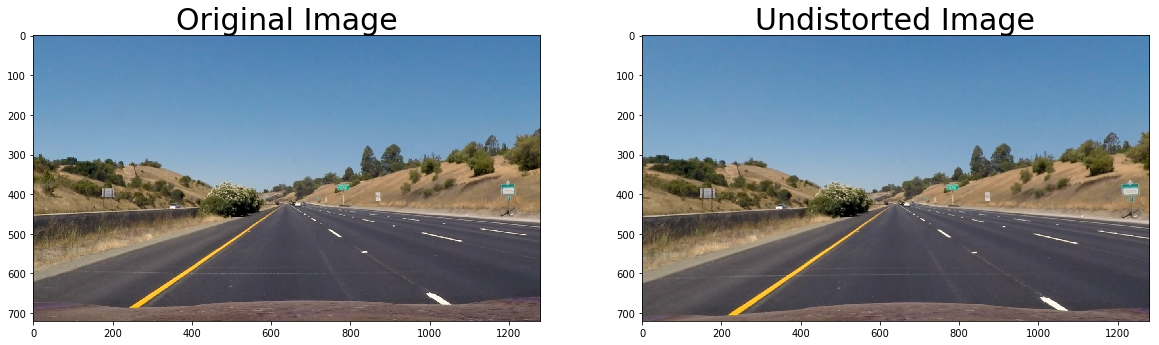

In [31]:
# Testing undistortion on an image
#img = cv2.imread('test_images/test5.jpg')
img = cv2.imread('test_images/straight_lines1.jpg')
img_size = (img.shape[0], img.shape[1])

# Converting to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Undistorting image
undst = cv2.undistort(img, mtx, dist, None, mtx)

# Saving jpg files
cv2.imwrite('road_undist.jpg',dst)
cv2.imwrite('road_dis.jpg', img)

# Converting BGR to RGB
undst_img = cv2.cvtColor(undst, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undst_img)
ax2.set_title('Undistorted Image', fontsize=30)
plt.show()

### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

In [32]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(img, orient='x', sobel_kernel = 3, thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # isn't mpimg.imread() should use BGR2GRAY to convert to gray?
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>=thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0 ,1, ksize=sobel_kernel))
    
    # 3) Calculate the magnitude 
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))
    
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    directions = np.arctan2(abs_sobely, abs_sobelx)
    
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(directions)
    binary_output[(directions>=thresh[0]) & (directions < thresh[1])] = 1 # Remove this line
    
    # 6) Return this mask as your binary_output image
    return binary_output


def color_threshold(img, thresh=(170, 255)):
    # Apply the following steps to img
    # 1) Convert to HLS: hue, lightness, saturation
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    
    # 2) Create a binary mask where color channel thresholds are met
    binary_output = np.zeros_like(s_channel)
    
    # 3) Reuturn this mask as your binary_output image
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    return binary_output

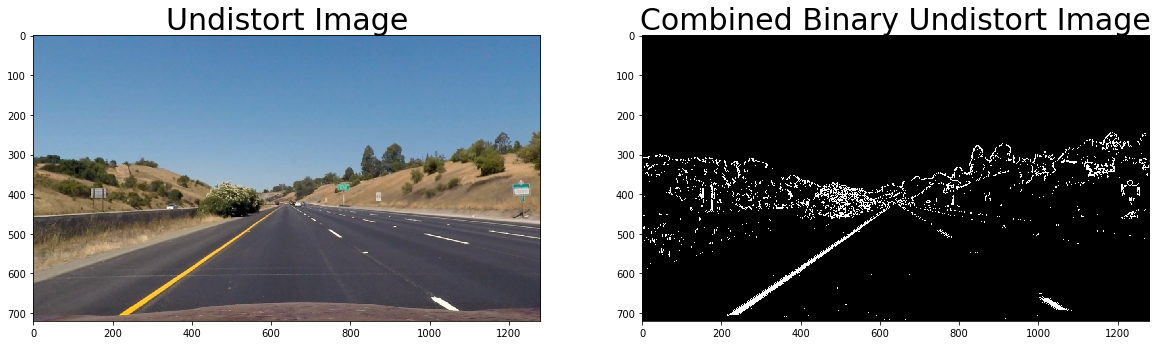

In [33]:
# test one image
image = undst_img

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(30, 100))
dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/4))
color_binary = color_threshold(image, thresh=(160, 255))

combined = np.zeros_like(dir_binary)
combined[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) | (color_binary == 1)] = 1

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Undistort Image', fontsize=30)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Binary Undistort Image', fontsize=30)
plt.show()


### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

Source points: 
 [[  578.           460.        ]
 [  193.33332825   720.        ]
 [ 1125.33337402   720.        ]
 [  705.           460.        ]]
Destination points: 
 [[ 320.    0.]
 [ 320.  715.]
 [ 960.  715.]
 [ 960.    0.]]


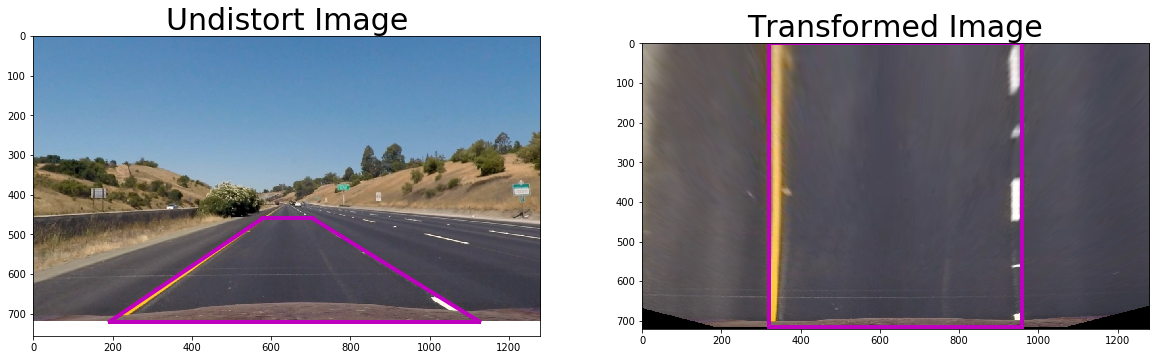

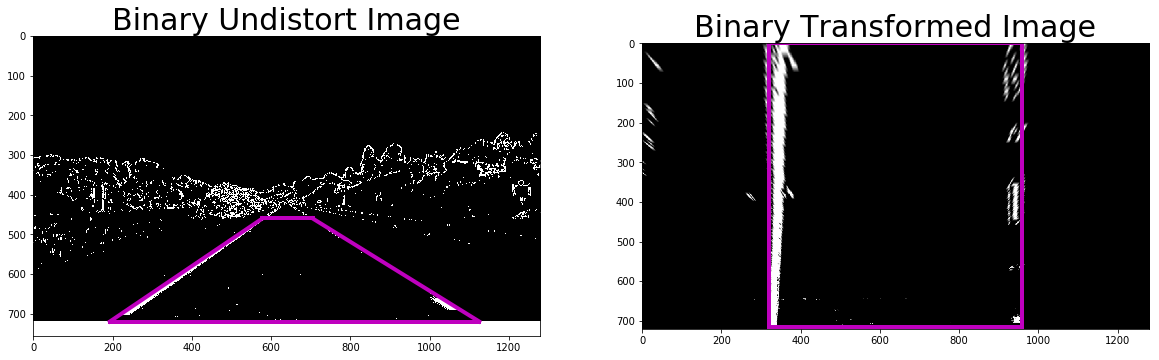

In [43]:
# image size
img_size = (image.shape[1], image.shape[0])

# Specify source points:
src_lt = [(img_size[0] / 2) - 62, img_size[1] / 2 + 100]
#src_lb = [((img_size[0] / 6) + 80), img_size[1]-70]
#src_rb = [(img_size[0] * 4 / 6) + 160, img_size[1]-70]
src_lb = [((img_size[0] / 6) - 20), img_size[1]]
src_rb = [(img_size[0] * 4 / 6) + 272, img_size[1]]
src_rt = [(img_size[0] / 2 + 65), img_size[1] / 2 + 100]
src = np.float32([src_lt, src_lb, src_rb, src_rt])
print('Source points: \n', src)

# Sepcify destination points:
dst_lt = [(img_size[0]/4), 0]
dst_lb = [(img_size[0]/4), img_size[1]-5]
dst_rb = [(img_size[0]*3/4), img_size[1]-5]
dst_rt = [(img_size[0]*3/4), 0]
dst = np.float32([dst_lt, dst_lb, dst_rb, dst_rt])
print('Destination points: \n', dst)

# Compute the perspective transform, M, given source and destination points:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

#Warp an image using the perspective transform, M:
#warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
binary_warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(image)
src_color = 'm'
lw = 4
ax1.set_title('Undistort Image', fontsize=30)
ax1.plot([src_lt[0], src_lb[0]], [src_lt[1], src_lb[1]],linewidth=lw, color=src_color)
ax1.plot([src_lb[0], src_rb[0]], [src_lb[1], src_rb[1]], linewidth=lw, color=src_color)
ax1.plot([src_rb[0], src_rt[0]], [src_rb[1], src_rt[1]], linewidth=lw, color=src_color)
ax1.plot([src_rt[0], src_lt[0]], [src_rt[1], src_lt[1]], linewidth=lw, color=src_color)
# ax1.line(src_lt, src_lb)
ax2.imshow(warped)
ax2.set_title('Transformed Image', fontsize=30)
dst_color = 'm'
ax2.plot([dst_lt[0], dst_lb[0]], [dst_lt[1], dst_lb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_lb[0], dst_rb[0]], [dst_lb[1], dst_rb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rb[0], dst_rt[0]], [dst_rb[1], dst_rt[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rt[0], dst_lt[0]], [dst_rt[1], dst_lt[1]], linewidth=lw, color=dst_color)
plt.show()


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(combined, cmap='gray')
src_color = 'm'
ax1.set_title('Binary Undistort Image', fontsize=30)
ax1.plot([src_lt[0], src_lb[0]], [src_lt[1], src_lb[1]],linewidth=lw, color=src_color)
ax1.plot([src_lb[0], src_rb[0]], [src_lb[1], src_rb[1]], linewidth=lw, color=src_color)
ax1.plot([src_rb[0], src_rt[0]], [src_rb[1], src_rt[1]], linewidth=lw, color=src_color)
ax1.plot([src_rt[0], src_lt[0]], [src_rt[1], src_lt[1]], linewidth=lw, color=src_color)
# ax1.line(src_lt, src_lb)
ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Binary Transformed Image', fontsize=30)
dst_color = 'm'
ax2.plot([dst_lt[0], dst_lb[0]], [dst_lt[1], dst_lb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_lb[0], dst_rb[0]], [dst_lb[1], dst_rb[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rb[0], dst_rt[0]], [dst_rb[1], dst_rt[1]], linewidth=lw, color=dst_color)
ax2.plot([dst_rt[0], dst_lt[0]], [dst_rt[1], dst_lt[1]], linewidth=lw, color=dst_color)
plt.show()

### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [44]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[np.int32(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
    (0,255,0), 4) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
    (0,255,0), 4) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

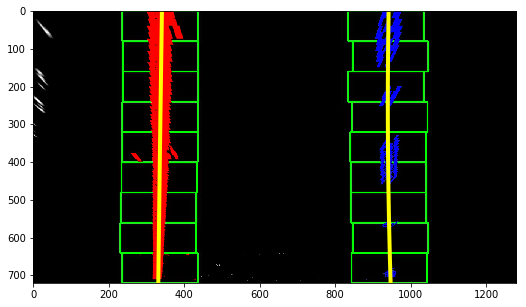

In [45]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
cv2.imwrite('out_img.jpg', out_img)
rec_img = cv2.imread('out_img.jpg')


plt.figure(figsize=(10,5))
plt.imshow(rec_img)
plt.plot(left_fitx, ploty, color='yellow', linewidth=4)
plt.plot(right_fitx, ploty, color='yellow', linewidth=4)
plt.xlim(0, img_size[0])
plt.ylim(img_size[1], 0)
plt.show()


### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [56]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(round(left_curverad, 2), round(right_curverad, 2))
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
#left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
#right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

# Calculate the new radius of curvature
left_curverad = np.int(((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0]))
right_curverad = np.int(((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0]))
# Now our radius of curvature is in meters
print("Radius of curvature: ", left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

# Calculate the position of the vehicle with respect to center
car_center_pix = img_size[0]/2
road_center_pix = leftx[0] + (rightx[0] - leftx[0])/2
diff_center_pix = car_center_pix - road_center_pix
diff_center_m = round(diff_center_pix * xm_per_pix,2)
print("Position of the vehicle with respect to center: ", diff_center_m, "m")

197623.47 14977.19
Radius of curvature:  64897 m 4912 m
Position of the vehicle with respect to center:  0.05 m


### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly

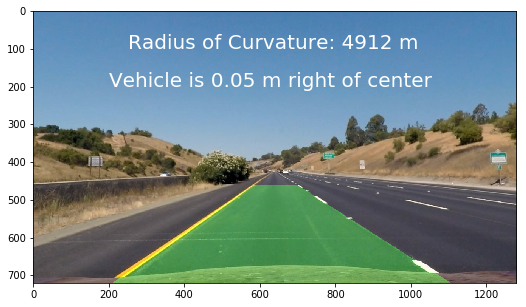

In [75]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right)).astype(np.int32)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
#cv2.fillPoly(color_warp, pts, (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(undst_img, 1, newwarp, 0.3, 0)
plt.figure(figsize=(10,5))
plt.imshow(result)
plt.text(250, 100, 'Radius of Curvature: '+ str(right_curverad) + ' m', fontsize=20, color = 'w')
dir_string = ['m left of center', 'm right of center']
plt.text(200, 200, 'Vehicle is '+ str(np.abs(diff_center_m)) + ' ' + dir_string[diff_center_m > 0], fontsize=20, color = 'w')
plt.show()

### Pipeline (video)

 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100), h_thresh=(0, 50)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold saturation channel
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    color_binary = s_binary
    
    return color_binary
    
result = pipeline(image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(result)
ax2.set_title('Pipeline Result', fontsize=40)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#plt.imshow(result[:,:, 0])

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2)/(x1 - x2)
            if slope < 0 and x1 < 500 and x2 < 500:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif slope > 0 and x1 > 500 and x2 > 500:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
                
    
    cv2.line(img, (min(left_x), max(left_y)), (max(left_x), min(left_y)), color, thickness)
    cv2.line(img, (max(right_x), max(right_y)), (min(right_x), min(right_y)), color, thickness)   
    
    # draw vertices
    #cv2.line(img, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][1][0], vertices[0][1][1]), color = [255, 255, 255], thickness = 5)
    #cv2.line(img, (vertices[0][2][0], vertices[0][2][1]), (vertices[0][3][0], vertices[0][3][1]), color = [255, 255, 255], thickness = 5)
    #cv2.line(img, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][3][0], vertices[0][3][1]), color = [255, 255, 255], thickness = 5)
    #cv2.line(img, (vertices[0][2][0], vertices[0][2][1]), (vertices[0][1][0], vertices[0][1][1]), color = [255, 255, 255], thickness = 5)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [ ]:
import os
image_list = os.listdir("test_images/")

In [ ]:
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
#plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
#plt.show()

# transform to grayscale
image_gray = grayscale(image)
cv2.imwrite( "grey.png", image_gray )
print("Transform to grayscale:")
plt.imshow(image_gray, cmap = plt.get_cmap('gray'))
#plt.imshow(cv2.cvtColor(image_gray, cv2.COLOR_BGR2RGB))
#plt.show()

# smooth image with Gaussian kernal
kernel_size = 5
image_gray_gaussian = gaussian_blur(image_gray, kernel_size)
#print("Smooth image:")
#plt.imshow(image_gray_gaussian)
#plt.show()

# apply canny edge detector
low_threshold = 50
high_threshold = 150
edges = canny(image_gray_gaussian, low_threshold, high_threshold)
#print("Apply edge detector:")
#plt.imshow(edges)
#plt.show()

# Next we'll create a masked edges image using cv2.fillPoly()
# This time we are defining a four sided polygon to mask
mask = np.zeros_like(image)   
ignore_mask_color = 255
imshape = image.shape
vertices = np.array([[(120,imshape[0]),(400, 340), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
#print("Apply mask:")
#plt.imshow(masked_edges)
#plt.show()

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 5    # minimum number of votes (intersections in Hough grid cell)
min_line_length = 5 #minimum number of pixels making up a line
max_line_gap = 2    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
linesimage= hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

final_image = weighted_img(linesimage, image, α=0.8, β=10., λ=0.)
plt.imshow(final_image)
plt.show()

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
#reading in an image
def image_edge_detection(imagefile = 'test_images/solidWhiteRight.jpg'):
    image = mpimg.imread(imagefile)

    # printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    #plt.show()

    # transform to grayscale
    image_gray = grayscale(image)
    cv2.imwrite( "grey.png", image_gray )
    print("Transform to grayscale:")
    plt.imshow(image_gray, cmap = plt.get_cmap('gray'))
    #plt.imshow(cv2.cvtColor(image_gray, cv2.COLOR_BGR2RGB))
    plt.show()
    
    # smooth image with Gaussian kernal
    kernel_size = 5
    image_gray_gaussian = gaussian_blur(image_gray, kernel_size)
    #print("Smooth image:")
    #plt.imshow(image_gray_gaussian)
    #plt.show()

    # apply canny edge detector
    low_threshold = 50
    high_threshold = 150
    edges = canny(image_gray_gaussian, low_threshold, high_threshold)
    #print("Apply edge detector:")
    #plt.imshow(edges)
    #plt.show()

    # Next we'll create a masked edges image using cv2.fillPoly()
    # This time we are defining a four sided polygon to mask
    mask = np.zeros_like(image)   
    ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(400, 340), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #print("Apply mask:")
    #plt.imshow(masked_edges)
    #plt.show()

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 2    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)
    #print("Apply hough transform: ")
    #plt.imshow(lines)
    #plt.show()

    # Create a "color" binary image to combine with line image
    final_image = weighted_img(lines, image, α=0.8, β=10., λ=0.)
    plt.imshow(final_image)
    plt.show()
    
    return final_image

In [ ]:
for image_name in image_list:
    image_file = 'test_images/' + image_name
    image_save = image_edge_detection(imagefile = image_file)
    # convert the color fom BGR to RGB, cv2 uses BGR as default
    RGB_img = cv2.cvtColor(image_save, cv2.COLOR_BGR2RGB)
    # save image
    cv2.imwrite('test_images_output/' + image_name[:-4] + '.jpg',RGB_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # transform to grayscale
    image_gray = grayscale(image)
    
    # smooth image with Gaussian kernel
    kernel_size = 5
    image_gray_gaussian = gaussian_blur(image_gray, kernel_size)

    # apply canny edge detector
    low_threshold = 50
    high_threshold = 150
    edges = canny(image_gray_gaussian, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    # This time we are defining a four sided polygon to mask
    mask = np.zeros_like(image)   
    ignore_mask_color = 255
    imshape = image.shape
    vertices = np.array([[(120,imshape[0]),(400, 340), (500, 320), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap)

    # Create a "color" binary image to combine with line image
    result = weighted_img(lines, image, α=0.8, β=10., λ=0.)
    
    return result

Let's try the one with the solid white lane on the right first ...

In [ ]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
yellow_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width = "960" height = "540" controls>
    <source src = "{0}">
<video/>
""".format(yellow_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [ ]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    img2 = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, vertices, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y1 - y2)/(x1 - x2)
            if slope < 0 and x1 < 600 and x2 < 600:
                left_x.append(x1)
                left_x.append(x2)
                left_y.append(y1)
                left_y.append(y2)
            elif slope > 0 and x1 > 680 and x2 > 680:
                right_x.append(x1)
                right_x.append(x2)
                right_y.append(y1)
                right_y.append(y2)
                
    
    cv2.line(img, (min(left_x), max(left_y)), (max(left_x), min(left_y)), color, thickness)
    cv2.line(img, (max(right_x), max(right_y)), (min(right_x), min(right_y)), color, thickness)   
    
    # draw vertices
    #cv2.line(img, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][1][0], vertices[0][1][1]), color = [255, 0, 255], thickness = 5)
    #cv2.line(img, (vertices[0][2][0], vertices[0][2][1]), (vertices[0][3][0], vertices[0][3][1]), color = [255, 0, 255], thickness = 5)
    #cv2.line(img, (vertices[0][0][0], vertices[0][0][1]), (vertices[0][3][0], vertices[0][3][1]), color = [255, 255, 255], thickness = 5)
    #cv2.line(img, (vertices[0][2][0], vertices[0][2][1]), (vertices[0][1][0], vertices[0][1][1]), color = [255, 0, 255], thickness = 5)
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, vertices):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, vertices)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def process_image_challenge(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # transform to grayscale
    image_gray = grayscale(image)
    
    # smooth image with Gaussian kernal
    kernel_size = 5
    image_gray_gaussian = gaussian_blur(image_gray, kernel_size)

    # apply canny edge detector
    low_threshold = 20
    high_threshold = 80
    edges = canny(image_gray_gaussian, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    # This time we are defining a four sided polygon to mask
    mask = np.zeros_like(image)   
    ignore_mask_color = 255
    imshape = image.shape
    # (720, 1280, 3)
    #vertices2 = np.array([[(80, imshape[0]),(600, 440), (740, 460), (imshape[1],imshape[0])]], dtype=np.int32)
    vertices2 = np.array([[(180, 680),(600, 440), (740, 440), (1140,660)]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices2)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 1    # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 2 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_length, max_line_gap, vertices2)

    # Create a "color" binary image to combine with line image
    result = weighted_img(lines, image, α=0.8, β=10., λ=0.)
    
    return result

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,2)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))